## Setup

In [ ]:
import numpy as np
import cv2
import matplotlib
from google.colab.patches import cv2_imshow

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
%matplotlib inline

print(tf.__version__)

2.14.0


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
# Move the files from the folder to root folder
%cd '/content/drive/MyDrive/CSC490'
%ls

%mv 'file1.zip' '/content/file1.zip'
%mv 'file2.zip' '/content/file2.zip'
%mv 'labels.txt' '/content/labels.txt'

%cd '/content'

/content/drive/.shortcut-targets-by-id/1DtNZCJmEvgFvi3J-wp4XxAdpP-bc8xH3/CSC490
'CSC490 ICVL DATASET'   file1.zip   file2.zip   labels.txt
mv: cannot remove 'file1.zip': Operation not permitted
mv: cannot remove 'file2.zip': Operation not permitted
mv: cannot remove 'labels.txt': Operation not permitted
/content


In [ ]:
# Unzip both files
!unzip file1.zip
!unzip file2.zip

Streaming output truncated to the last 5000 lines.
  inflating: -112-5/201406181554/image_4756.png  
  inflating: -112-5/201406181554/image_4758.png  
  inflating: -112-5/201406181554/image_4760.png  
  inflating: -112-5/201406181554/image_4762.png  
  inflating: -112-5/201406181554/image_4764.png  
  inflating: -112-5/201406181554/image_4766.png  
  inflating: -112-5/201406181554/image_4768.png  
  inflating: -112-5/201406181554/image_4770.png  
  inflating: -112-5/201406181554/image_4772.png  
  inflating: -112-5/201406181554/image_4774.png  
  inflating: -112-5/201406181554/image_4850.png  
  inflating: -112-5/201406181554/image_4852.png  
  inflating: -112-5/201406181554/image_4854.png  
  inflating: -112-5/201406181554/image_4856.png  
  inflating: -112-5/201406181554/image_4858.png  
  inflating: -112-5/201406181554/image_4860.png  
  inflating: -112-5/201406181554/image_4862.png  
  inflating: -112-5/201406181554/image_4864.png  
  inflating: -112-5/201406181554/image_4866.png  

In [ ]:
!mkdir Depth
!mv '/content/112-5/' 'Depth/'
!mv '/content/-112-5/' 'Depth/'

# Cleanup
!rm -r '/content/112-5/'
!rm -r '/content/-112-5/'

rm: cannot remove '/content/112-5/': No such file or directory
rm: cannot remove '/content/-112-5/': No such file or directory


* Each line has 16x3 numbers, which indicates (x, y, z) of 16 joint locations. Note that these are joint CENTRE locations.
* Note that (x, y) are in pixels and z is in mm.
* The order of 16 joints is Palm, Thumb root, Thumb mid, Thumb tip, Index root, Index mid, Index tip, Middle root, Middle mid, Middle tip, Ring root, Ring mid, Ring tip, Pinky root, Pinky mid, Pinky tip.

In [ ]:
# Read coordinates from the text file
with open("labels.txt", "r") as label:
    coordinates = [line.strip().split() for line in label]
print(coordinates[1])

['-112-5/201403121135/image_0001.png', '160.00', '120.00', '272.97', '159.58', '93.90', '256.41', '186.69', '78.78', '253.91', '209.14', '71.20', '244.33', '212.76', '119.41', '262.33', '237.67', '126.51', '253.47', '254.91', '131.81', '245.64', '204.27', '137.82', '269.44', '229.67', '153.82', '259.56', '246.63', '165.67', '249.84', '188.60', '147.80', '272.00', '210.77', '163.26', '265.08', '226.19', '174.81', '257.94', '169.34', '158.83', '276.63', '181.09', '175.34', '273.19', '189.83', '189.62', '265.59']


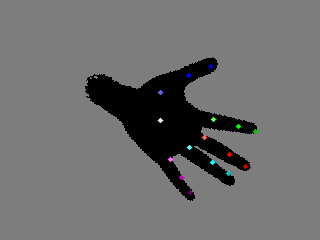

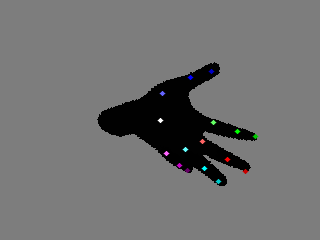

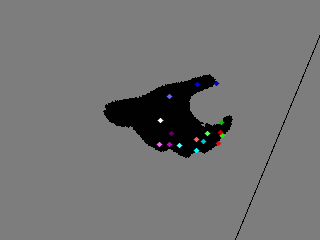

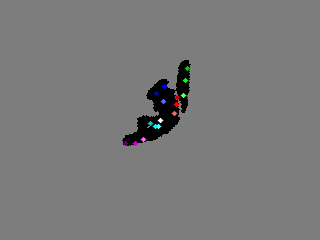

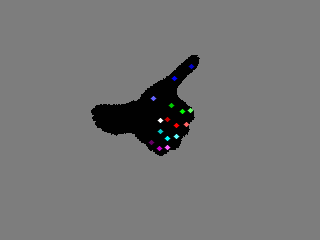

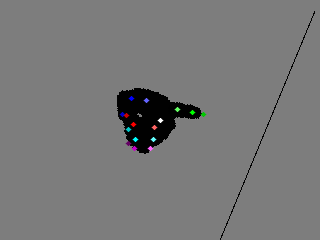

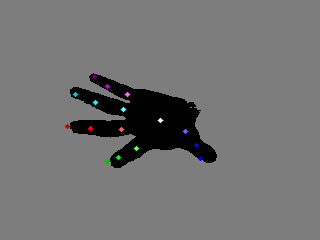

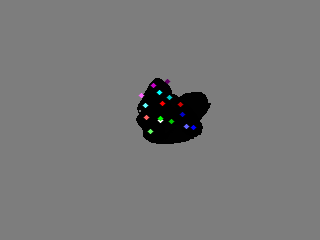

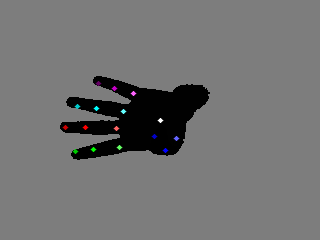

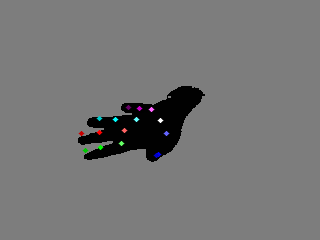

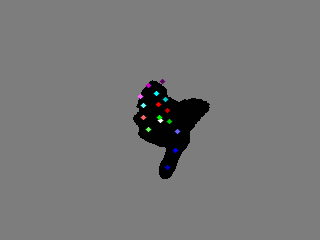

In [ ]:
# Create a color map for finger joints
joint_colors = [
  (255, 255, 255),  # Palm
  (255, 100, 100),  # Thumb root
  (255, 0, 0),      # Thumb mid
  (200, 0, 0),      # Thumb tip
  (100, 255, 100),  # Index root
  (0, 255, 0),      # Index mid
  (0, 200, 0),      # Index tip
  (100, 100, 255),  # Middle root
  (0, 0, 255),      # Middle mid
  (0, 0, 200),      # Middle tip
  (255, 255, 100),  # Ring root
  (255, 255, 0),    # Ring mid
  (200, 200, 0),    # Ring tip
  (255, 100, 255),  # Pinky root
  (200, 0, 200),    # Pinky mid
  (100, 0, 100)     # Pinky tip
]

# There are 5354 photos in -112-5.zip
# Maximum index for coordinates for NOW is 5353

# Visualizing the images with the joints
for i in range(0, 5353, 500):
  c = coordinates[i]

  filename = "/content/Depth/" + c[0]
  # filename = c[0]

  # Load the hand mask image
  img = cv2.imread(filename)

  c = c[1:]
  for j in range(0,len(c),3):
    x = int(float(c[j]))
    y = int(float(c[j+1]))
    z = float(c[j+2])
    color = joint_colors[j//3]
    # Draw a circle for the finger joint
    cv2.circle(img, (x, y), 2, color, -1, lineType=cv2.LINE_AA)

    # Add the z-coordinate as text
    # cv2.putText(img, str(z), (x - 20, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, color, 1)
  cv2_imshow(img)

In [ ]:
RAND_SEED = 42

IMG_WIDTH = 320
IMG_HEIGHT = 240

IMG_DIM = (IMG_HEIGHT, IMG_WIDTH)

DATA_FOLDERS = set(['-112-5', '112-5']) # Only get labels from these folders

Model Architechture

- Input: a 320 x 240 Masked Image

- Output: a prediction of 48 coordinates (x, y, z) of 16 joints.

In [ ]:
len(coordinates[1]) # - 1 from fname

49

In [ ]:
with open('labels.txt', 'r') as f:
  labels = [line.strip().split() for line in f]

In [ ]:
img_fnames = []
targets = []

for label in labels:

  img_fname, target = label[0], label[1:]

  base_folder = img_fname.split('/')[0]

  if base_folder not in DATA_FOLDERS:
    continue

  img_fnames.append(img_fname)
  targets.append([float(t) for t in target])

# How mach data we have
len(img_fnames), len(targets)

(44134, 44134)

In [ ]:
#@title Splitting the data
from sklearn.model_selection import train_test_split

max_data = 5000 # IMPORTANT! NOTE:

X = img_fnames[:max_data]
Y = targets[:max_data]

# 1-test_size = Train %
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=RAND_SEED
)

# Splitting validation and test set

# 30% total - 75% of it used for val, 25% of the rest used for train
X_val, X_test, y_val, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.25,
    random_state=RAND_SEED
)

len(X_train), len(X_val), len(X_test)

(3500, 1125, 375)

In [ ]:
import PIL.Image

def normalize_img_arr(img_arr: np.array) -> np.array:
    uniqs = np.unique(img_arr)

    # Getting the max distance, which serves as 0 in a depth image (no information)
    max_dist = uniqs[-1]
    img_arr[img_arr == max_dist] = 0

    # Normalizing range of hand distances between 0-1
    min_norm = uniqs[0]
    max_norm = uniqs[-2]
    img_arr /= max_norm

    return img_arr


def load_X(X, y):
    """ Converts filenames in X to an array of pixels representing image from filesnames in X """
    X = np.array(X)
    new_X = []
    with tqdm(total=len(X)) as pbar:
        for img_fpath in X:
            with PIL.Image.open(f"/content/Depth/{img_fpath}") as img:
                #print(img_fpath)
                #display(img)
                img_data = np.asarray(img, np.float32)
                img_data = normalize_img_arr(img_data)

                # Reshape
                img_data = np.reshape(img_data, (240, 320, 1))

                new_X.append(img_data)
                pbar.update(1)

        return np.array(new_X)

X_train_img_arr = load_X(X_train, y_train)
X_val_img_arr = load_X(X_val, y_val)
X_train_img_arr.shape

100%|██████████| 1125/1125 [00:04<00:00, 255.24it/s]


(3500, 240, 320, 1)

In [ ]:
def load_Y(y):
    y = np.asarray(y, np.float32)
    return y

y_train_arr = load_Y(y_train)
y_val_arr = load_Y(y_val)
y_train_arr.shape

(3500, 48)

# Training the model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(include_top=False,
                      weights=None,
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 1))
# Flatten output layer of Resnet + Add your own layers for regression
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(256,
                          activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output_layer = tf.keras.layers.Dense(48,
                                     activation='linear',
                                     name="DenseOutput")(x)
# Initialize Model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
#@title Compiling the model

loss_fn = tf.keras.losses.CosineSimilarity(
    axis=-1, reduction="auto", name="cosine_similarity"
)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mae',
              metrics=['mae'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 320, 1)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 246, 326, 1)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 120, 160, 64)         3200      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 120, 160, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np

BATCH_SIZE = 16

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train_img_arr, y_train_arr, BATCH_SIZE)
val_gen = DataGenerator(X_val_img_arr, y_val_arr, BATCH_SIZE)

In [ ]:
input_image = np.reshape(X_train_img_arr[:BATCH_SIZE], (BATCH_SIZE, 240, 320, 1))

In [ ]:
# X_train_img_arr[0].shape
preds = model.predict(X_train_img_arr[:BATCH_SIZE])
preds[0].shape, preds.shape

1/1 [==============================] - 6s 6s/step


((48,), (16, 48))

In [ ]:
import os

checkpoint_path = "/content/drive/MyDrive/CSC490 Weights/training_ckpt/resnet_{epoch:02d}.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 mode='auto',
                                                 save_freq="epoch",
                                                 save_weights_only=True,
                                                 verbose=1,
                                                )
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=4)

In [ ]:
!cd '/content/drive/MyDrive/CSC490 Weights/'
f = open('/content/drive/MyDrive/CSC490 Weights/test_example.txt', 'w')
f.write('a\nb\nc\n')
f.close()

In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    verbose=1,
    validation_data=val_gen,
    callbacks=[cp_callback, early_stop_callback]
)

Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 36.1462 - mae: 36.1462 
Epoch 1: saving model to /content/drive/MyDrive/CSC490 Weights/training_ckpt/resnet_01.h5
219/219 [==============================] - 4158s 19s/step - loss: 36.1462 - mae: 36.1462 - val_loss: 32.2460 - val_mae: 32.2460
Epoch 2/10
177/219 [=======================>......] - ETA: 11:59 - loss: 31.4715 - mae: 31.4715